In [1]:
import numpy as np 

## Coordinates obtained from a subjects T1 MRI scan using freeview and TKReg RAS native subject space in order to target the left Hippocampus

pa0 = [34.530, -7.813, 78.808]
pa1 = [62.576, 45.917, 31.380]

pb0 = [70.234, -5.015, 6.388]
pb1 = [70.044, 19.886, 12.108]


coordinates = np.array([pa0, pa1, pb0, pb1])

In [2]:
coordinates

array([[34.53 , -7.813, 78.808],
       [62.576, 45.917, 31.38 ],
       [70.234, -5.015,  6.388],
       [70.044, 19.886, 12.108]])

In [7]:
builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
for montage_name, montage_description in builtin_montages:
    print(f"{montage_name}: {montage_description}")

standard_1005: Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
standard_1020: Electrodes are named and positioned according to the international 10-20 system (94+3 locations)
standard_alphabetic: Electrodes are named with LETTER-NUMBER combinations (A1, B2, F4, …) (65+3 locations)
standard_postfixed: Electrodes are named according to the international 10-20 system using postfixes for intermediate positions (100+3 locations)
standard_prefixed: Electrodes are named according to the international 10-20 system using prefixes for intermediate positions (74+3 locations)
standard_primed: Electrodes are named according to the international 10-20 system using prime marks (' and '') for intermediate positions (100+3 locations)
biosemi16: BioSemi cap with 16 electrodes (16+3 locations)
biosemi32: BioSemi cap with 32 electrodes (32+3 locations)
biosemi64: BioSemi cap with 64 electrodes (64+3 locations)
biosemi128: BioSemi cap with 128 electrodes (1

In [12]:
import mne
import numpy as np
from scipy.spatial.distance import cdist

simnibs_labels = ["Coord_pa0", "Coord_pa1", "Coord_pb0", "Coord_pb1"]

montage_name = 'standard_1020'

montage = mne.channels.make_standard_montage(montage_name)


# 2. Get channel names and coordinates (in meters) from the montage
ch_names = montage.ch_names
montage_coords_dict = montage.get_positions()['ch_pos'] # Gets positions as a dict
# Convert dict to an ordered array corresponding to ch_names
montage_coords_m_array = np.array([montage_coords_dict[ch] for ch in ch_names])

print(f"Number of channels in {montage_name}: {len(ch_names)}")
print("-" * 20)

Number of channels in standard_1020: 94
--------------------


In [13]:
# --- Calculate Distances and Find Closest Channels ---

# 3. Calculate pairwise Euclidean distances
# Input arrays shape: (n_simnibs_points, 3) and (n_montage_points, 3)
distances = cdist(coordinates, montage_coords_m_array)
# Result 'distances' shape: (n_simnibs_points, n_montage_points)

In [14]:
# 4. Find the index of the minimum distance for each SimNIBS coordinate
closest_indices = np.argmin(distances, axis=1)

# --- Print Results ---
print("--- Closest EEG Channels ---")
for i, simnibs_label in enumerate(simnibs_labels):
    closest_montage_idx = closest_indices[i]
    closest_ch_name = ch_names[closest_montage_idx]
    min_dist_m = distances[i, closest_montage_idx]

    print(f"Input Coord: {simnibs_label} {coordinates[i]} (mm)")
    print(f"  -> Closest {montage_name} channel: {closest_ch_name} ")
    print(f"     Distance: {min_dist_m * 1000:.2f} mm") # Convert back to mm for printing
    print("-" * 10)

--- Closest EEG Channels ---
Input Coord: Coord_pa0 [34.53  -7.813 78.808] (mm)
  -> Closest standard_1020 channel: CP2 
     Distance: 86292.50 mm
----------
Input Coord: Coord_pa1 [62.576 45.917 31.38 ] (mm)
  -> Closest standard_1020 channel: F6 
     Distance: 83634.54 mm
----------
Input Coord: Coord_pb0 [70.234 -5.015  6.388] (mm)
  -> Closest standard_1020 channel: CP6 
     Distance: 70613.15 mm
----------
Input Coord: Coord_pb1 [70.044 19.886 12.108] (mm)
  -> Closest standard_1020 channel: FC6 
     Distance: 73727.20 mm
----------


In [16]:
channels_to_highlight = [ch_names[idx] for idx in closest_indices]
channels_to_highlight = sorted(list(set(channels_to_highlight)))
info = mne.create_info(ch_names=montage.ch_names, sfreq=100, ch_types='eeg')
info.set_montage(montage)
info['bads'] = channels_to_highlight

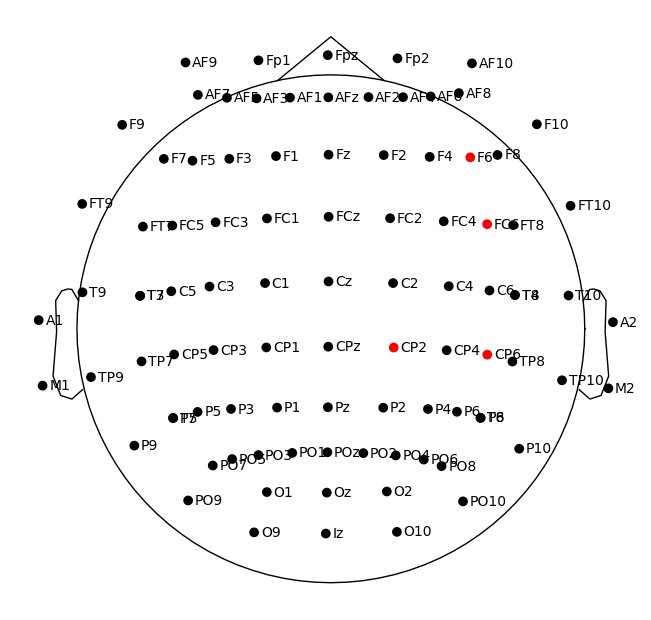

In [17]:
fig = mne.viz.plot_sensors(info, kind='topomap', show_names=True)